<a href="https://colab.research.google.com/github/maazfaisal02/linear-regression/blob/main/cs4375_ao1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install ucimlrepo

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

In [8]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
student_performance = fetch_ucirepo(id=320)

# Load the data
X = student_performance.data.features
y = student_performance.data.targets['G3']  # We'll predict the final grade

In [9]:
# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'bool']).columns

In [10]:
# Create preprocessing pipelines for both numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', sparse=False))
])

In [11]:
# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [12]:
# Fit and transform the data
X_processed = preprocessor.fit_transform(X)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [13]:
# Get feature names after preprocessing
onehot_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
cat_feature_names = onehot_encoder.get_feature_names_out(categorical_features)
feature_names = list(numeric_features) + list(cat_feature_names)

In [14]:
# Convert to DataFrame
X_processed = pd.DataFrame(X_processed, columns=feature_names)

In [15]:
# Remove G1 and G2 as they're highly correlated with G3
features_to_drop = ['G1', 'G2']
X_processed = X_processed.drop(columns=features_to_drop, errors='ignore')

In [16]:
# Split the dataset into (80%) training and testing (20%) data
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

In [17]:
# Define the gradient descent function
def gradient_descent(X, y, learning_rate, num_iterations):
    m, n = X.shape
    theta = np.zeros(n)

    for _ in range(num_iterations):
        h = np.dot(X, theta)
        gradient = (1/m) * np.dot(X.T, (h - y))
        theta -= learning_rate * gradient

    return theta

In [18]:
# Define the mean squared error function
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

In [19]:
# Hyperparameter tuning
learning_rates = [0.01, 0.1, 0.25]
num_iterations_list = [1000, 5000, 10000]

best_mse = float('inf')
best_params = {}
log = []

for lr in learning_rates:
    for num_iter in num_iterations_list:
        theta = gradient_descent(X_train.values, y_train.values, lr, num_iter)
        y_pred = np.dot(X_train.values, theta)
        current_mse = mse(y_train.values, y_pred)

        log.append({
            'learning_rate': lr,
            'num_iterations': num_iter,
            'mse': current_mse
        })

        if current_mse < best_mse:
            best_mse = current_mse
            best_params = {'learning_rate': lr, 'num_iterations': num_iter}

In [20]:
# Save log to file
log_df = pd.DataFrame(log)
log_df.to_csv('hyperparameter_tuning_log.csv', index=False)
log_df

,learning_rate,num_iterations,mse
0,0.01,1000,9.024973
1,0.01,5000,8.608876
2,0.01,10000,8.563222
3,0.10,1000,8.563198
4,0.10,5000,8.550912
5,0.10,10000,8.550911
6,0.25,1000,8.551204
7,0.25,5000,8.550911
8,0.25,10000,8.550911


In [21]:
# Train the model with the best parameters
best_theta = gradient_descent(X_train.values, y_train.values,
                              best_params['learning_rate'],
                              best_params['num_iterations'])

In [22]:
# Evaluate on test set
y_pred_test = np.dot(X_test.values, best_theta)
test_mse = mse(y_test.values, y_pred_test)


In [23]:
print(f"Best parameters: {best_params}")
print(f"Best training MSE: {best_mse}")
print(f"Test MSE: {test_mse}")

Best parameters: {'learning_rate': 0.25, 'num_iterations': 10000}
Best training MSE: 8.55091082993832
Test MSE: 9.519149459969361


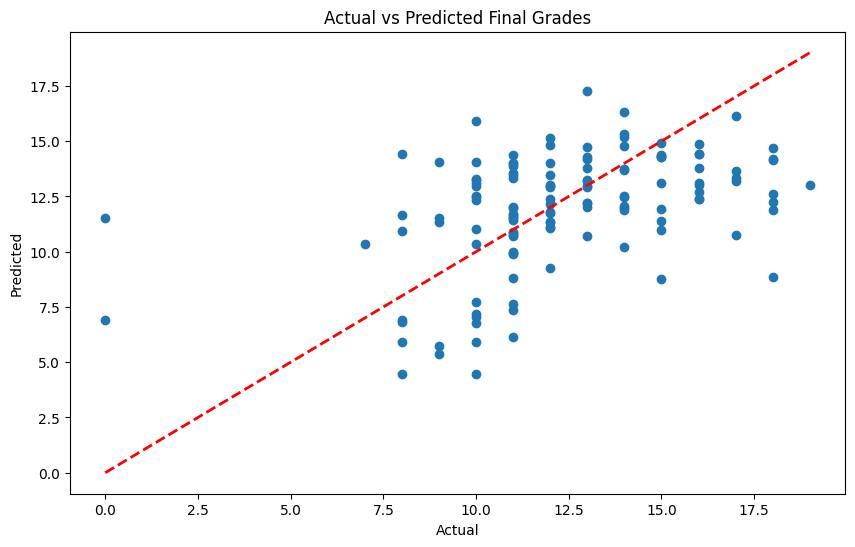

In [24]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted Final Grades")
plt.savefig('actual_vs_predicted.png')

In [25]:
# Feature importance
feature_importance = pd.DataFrame({'feature': X_processed.columns, 'importance': np.abs(best_theta)})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nTop 10 most important features:")
print(feature_importance.head(10))


Top 10 most important features:
           feature  importance
36      higher_yes    3.629854
25    Fjob_teacher    3.013038
23      Fjob_other    2.548736
22     Fjob_health    2.322029
30  guardian_other    2.064339
17       Pstatus_T    2.035303
18     Mjob_health    1.804962
24   Fjob_services    1.792397
15       address_U    1.372841
20   Mjob_services    1.246350
